
 # Finite Differences - Time Reversal - Acoustic 2D
       
 
 * Run the code and appreciate the forward and propagating wavefields
 
 #### Exercise:
 
 * Change the number of receivers around the source and observe the change in focusing quality!
 * Relevant line: **nr = 20  # number of receievers**


## Basics

If the positions of the source and receiver are interchanged then the same seismogram should be recorded according to the principle of reciprocity. Using that principle one can reinject seismograms at the receiver locations. If the geometrical cover is sufficient the wavefield will focus at the source and the right source time. 


In [5]:
# CONFIGURATION STEP (Please run it before the simulation code!)

import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.facecolor'] = 'w'          # remove grey background

import warnings                                        
warnings.filterwarnings("ignore")                      # ignore Warning Messages


<IPython.core.display.Javascript object>


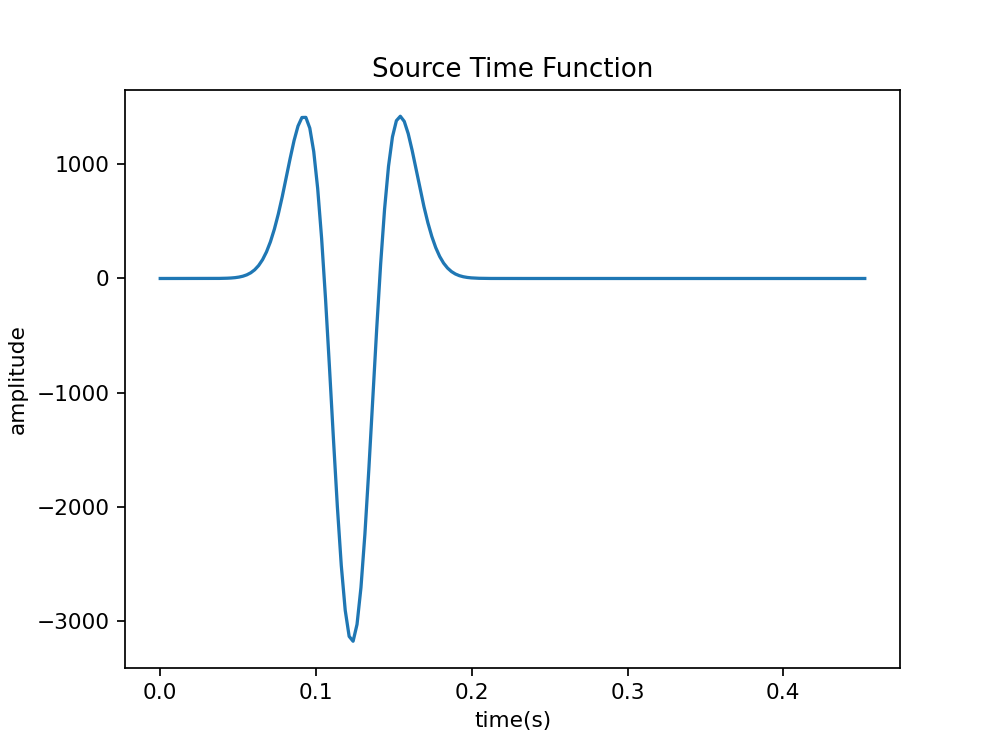

In [6]:
# BASIC PARAMETERS

nt    = 180                                            # number of time steps
c0    = 1.                                             # acoustic velocity
eps   = 0.5                                            # stability limit
isnap = 10                                             # plot frequency
nx    = 200                                            # number of grid points in x
nz    = nx                                             # number of grid points in y

# Initialize empty pressure
p     = np.zeros((nz, nx))                             # p at time n (now)
pold  = np.zeros((nz, nx))                             # p at time n-1 (past)
pnew  = np.zeros((nz, nx))                             # p at time n+1 (present)
d2px  = np.zeros((nz, nx))                             # 2nd space derivative of p in x-direction
d2pz  = np.zeros((nz, nx))                             # 2nd space derivative of p in z-direction
c     = np.zeros((nz, nx))                             # velocity field
c     = c + c0                                         # velocity model (here homogeneous)
cmax  = c.max()

# Receivers
nr    = 100                                             # number of receievers
rec   = np.zeros ((2, nr), dtype=np.int32)             # empty receivers
seis1  = np.zeros ((nt, nr))                           # empty seismograms (at circular receivers)

phi   = np.linspace (0, 2 * np.pi, nr+1)
for i in range (0, nr):
    rec[0,i] = 100 + np.floor(50 * (np.cos(phi[i])))
    rec[1,i] = 100 + np.floor(50 * (np.sin(phi[i])))

isx   = nx//2                                          # source location in x-direction
isz   = nz//2                                          # source location in z-direction

# Grid initialization
dx    = 1. / (nx-1)                                    # space increment in x-direction
dz    = dx                                             # space increment in z-direction

x     = np.arange(0, nx) * dx                          # initialize space coordinates in x-direction
z     = np.arange(0, nz) * dz                          # initialize space coordinates in z-direction
dt    = eps * dx / (c.max())                           # calculate time step from stability criterion 

# Source time function
f0    = 1. / (10. * dt)                                # dominant frequency
t     = np.linspace(0 * dt, nt * dt, nt)               # initialize time axis
t0    = 5. / f0                                        # shifting of source time function

src   = np.zeros(nt+1)
src   = np.exp(-1.0* (f0**2) * (t-t0)**2)              # Gaussian
src   = np.diff(src) / dt                              # first derivative of Gaussian
src   = np.append(src,0.)
src   = np.diff(src) / dt                              # second derivative of Gaussian
src   = np.append(src, 0.)

# Plotting the source-time function
fig0 = plt.figure(0)
plt.title('Source Time Function')
plt.plot(t,src)
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.show()


Wavefield at increasing iterations calculated with 2D finite difference scheme.


<IPython.core.display.Javascript object>


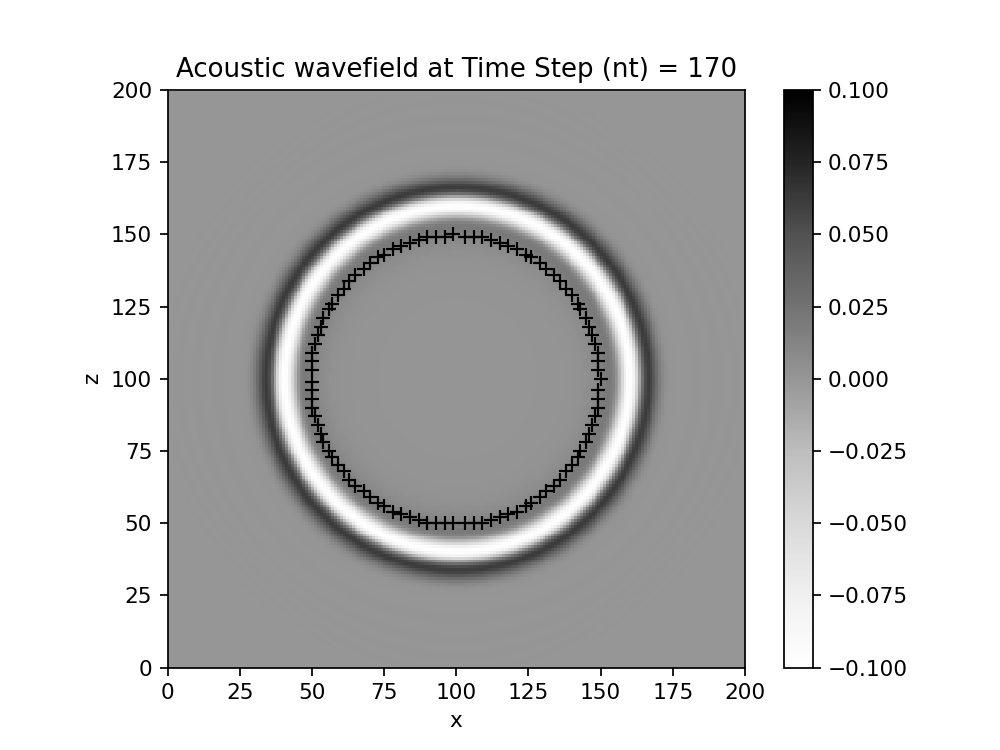

In [7]:
# EXTRAPOLATION SCHEME AND PLOTS

# Initialize Plot
print("Wavefield at increasing iterations calculated with 2D finite difference scheme.")
fig1   = plt.figure(1)
v      = max([np.abs(p.min()), np.abs(p.max())])

image1 = plt.imshow(pnew, interpolation='nearest', animated=True,
                   vmin=-v, vmax=+v, cmap=plt.cm.Greys)

# Plot Receivers
for i in range (0, nr):
    plt.plot(rec[0,i], rec[1,i], 'k+')

plt.colorbar()
plt.xlim(0,nx)
plt.ylim(0,nz)
plt.xlabel('x')
plt.ylabel('z')

plt.ion()
plt.show()

# Time Stepping
for it in range(0,nt):                                 # 5 point operator FD scheme
    
    # Space derivative in x-direction
    for i in range(2, nx - 2):
        d2px[i, :] = (- 1. / 12 * p[i + 2, :] + 4. / 3  * p[i + 1, :] - 5. / 2 * p[i, :] \
                      + 4. / 3  * p[i - 1, :] - 1. / 12 * p[i - 2, :]) / dx ** 2
    
    # Space derivative in z-direction
    for j in range(2, nz - 2):
        d2pz[:, j] = (- 1. / 12 * p[:, j + 2] + 4. / 3  * p[:, j + 1] - 5. / 2 * p[:, j] \
                      + 4. / 3  * p[:, j - 1] - 1. / 12 * p[:, j - 2]) / dz ** 2 
    
    # Time Extrapolation
    pnew = 2 * p - pold + dt ** 2 * c ** 2 * (d2px + d2pz)
    
    # Add Source Term at isx, isz
    pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt ** 2)

    # Plot Every Time Step
    if (it % isnap) == 0:
        plt.title('Acoustic wavefield at Time Step (nt) = %d' % it)
        v      = max([np.abs(p.min()), np.abs(p.max())])
        
        image1 = plt.imshow(pnew, interpolation ='nearest', animated= True,
                            vmin = -v, vmax = +v, cmap=plt.cm.Greys)
        
        plt.gcf().canvas.draw()
        
    # Remap Time Levels
    pold, p = p, pnew
    
    # Save Seismograms
    for i in range (0, nr):
        seis1[it, i] = p[rec[0,i], rec[1,i]]


<IPython.core.display.Javascript object>


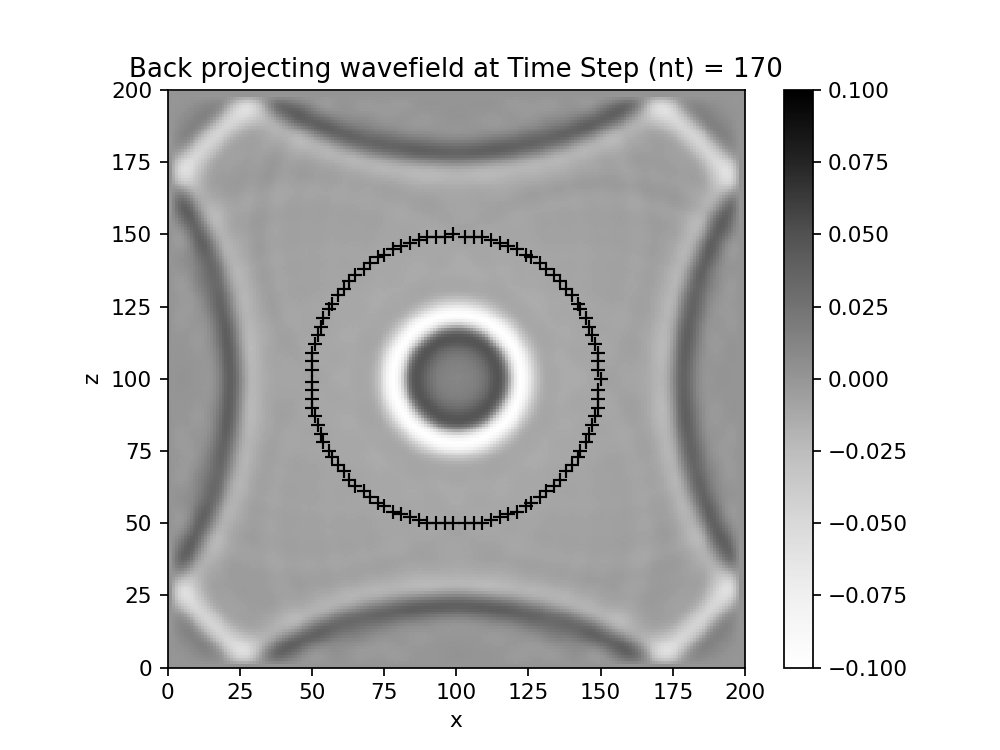

<IPython.core.display.Javascript object>


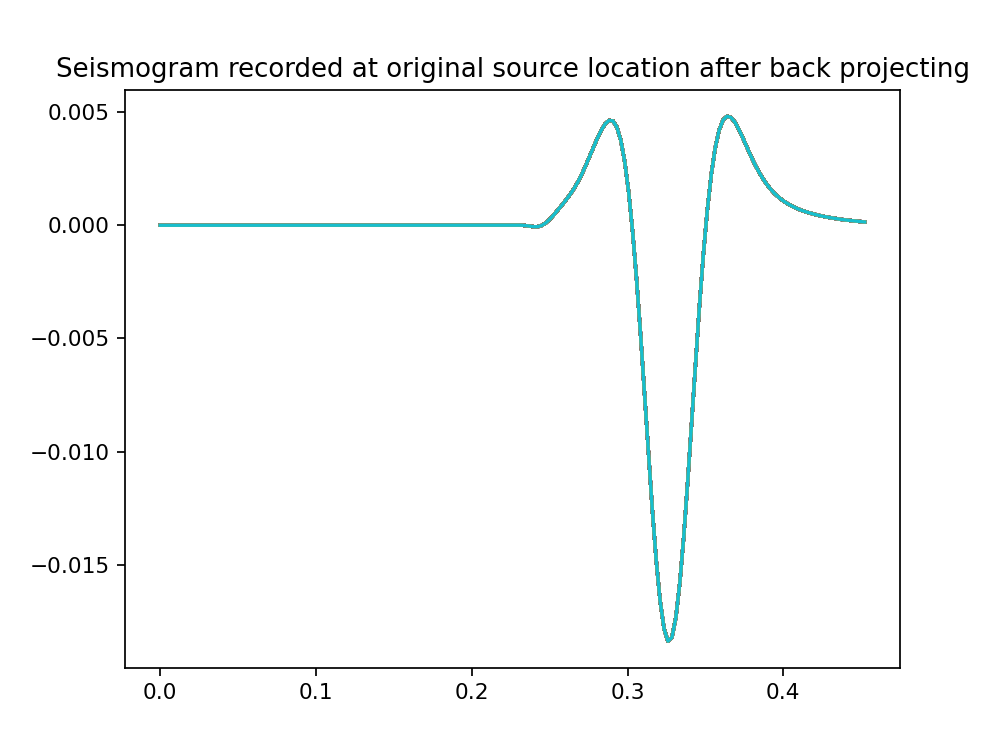

In [8]:
# REVERSAL

# Initialization of pressure field
p     = np.zeros((nz, nx))                                 # initialize pressure field as before
pnew  = np.zeros((nz, nx))
pold  = np.zeros((nz, nx))
d2px  = np.zeros((nz, nx))
d2pz  = np.zeros((nz, nx))
seis2 = np.zeros((nt, nr))                                 # empty seismograms

# Initailze plot
fig2  = plt.figure(2)
v1    = max([np.abs(p.min()), np.abs(p.max())])

image2 = plt.imshow(pnew, interpolation='nearest', animated=True,
                    vmin = -v1, vmax = +v1, cmap=plt.cm.Greys)

# Plot Receivers
for i in range (0, nr):
    plt.plot(rec[0,i], rec[1,i], 'k+')

plt.colorbar()
plt.xlim(0,nx)
plt.ylim(0,nz)
plt.xlabel('x')
plt.ylabel('z')

plt.ion()
plt.show()

# Time stepping
for it in range (0,nt):                                # 5 point operator FD scheme
    
    # Space derivative in x-direction
    for i in range(2, nx - 2):
        d2px[i, :] = (-1./12 * p[i + 2,:] +4./3  * p[i + 1,:] -5./2 * p[i,:] \
                      +4./3  * p[i - 1,:] -1./12 * p[i - 2,:]) / (dx ** 2) 
    
    # Space derivative in z-direction
    for j in range(2, nz - 2):
        d2pz[:, j] = (-1./12 * p[:,j + 2] +4./3  * p[:,j + 1] -5./2 * p[:,j] \
                      +4./3  * p[:,j - 1] -1./12 * p[:,j - 2]) / (dz ** 2) 
    
    # Time Extrapolation
    pnew = 2 * p - pold + dt ** 2 * c ** 2 * (d2px + d2pz)
    
    # Add source term
    # Remember we are injecting previously recorded seismograms as sources.
    for i in range(0,nr):
        pnew[rec[1,i], rec[0,i]] = pnew[rec[1,i], rec[0,i]] + seis1[nt-2-it,i] * dt**2

    # Plot every time step
    if (it % isnap) == 0:
        plt.title('Back projecting wavefield at Time Step (nt) = %d' % it)
        v1 = max([np.abs(p.min()), np.abs(p.max())])

        image2 = plt.imshow(pnew, interpolation='nearest', animated=True,
                            vmin = -v1, vmax = +v1, cmap=plt.cm.Greys)
        
        plt.gcf().canvas.draw()
        
    # Remap time levels
    pold, p = p, pnew

    # Save Seismograms recorded at source location for previous simulation
    for i in range (0, nr):
        seis2[it, i] = p[isx, isz]

# Plot the recorded seismogram at previous source location
fig3 = plt.figure(3)
plt.plot(t,seis2)
plt.title("Seismogram recorded at original source location after back projecting")
plt.show()